In [39]:
# not a standatrd library
!pip install livelossplot --quiet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tqdm
import copy
import random
import time
import os
from livelossplot import PlotLosses
from utils import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
SEED = 123
random.seed(SEED)
np.random.seed(SEED)

In [3]:
# load gpu usage and set dicts for data loading
device = 'cuda' if torch.cuda.is_available() else 'cpu'
!mkdir "/content/images"
!cp "/content/drive/MyDrive/Colab Notebooks/images.zip" "/content/images"
!cp "/content/drive/MyDrive/Colab Notebooks/utils.py" "."
output = !unzip "/content/images/images.zip" -d "/content/images"
wbc__label_name = {0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}
wbc__name_label = {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

mkdir: cannot create directory ‘/content/images’: File exists


In [4]:
# function for loading the images from folders
def load_from_folder(folder_path):
  x = []
  y = []
  train_folder = folder_path
  for wbc_type in os.listdir(train_folder):
      if not wbc_type.startswith('.'):
          label = wbc__name_label[wbc_type]
          cell_type_folder = train_folder + wbc_type
          for i, image_filename in enumerate(os.listdir(cell_type_folder)):
              if not wbc_type.startswith('.'):
                x.append(cell_type_folder + '/' + image_filename)
                y.append(label)
                # if i == 500:
                #     break
  return x, y

In [5]:
# loading the data
train_folder = '/content/images/images/TRAIN/'
test_folder = '/content/images/images/TEST/'
images, labels = load_from_folder(train_folder)
test_images, test_labels = load_from_folder(test_folder)

In [6]:
# transforming to tensors to calculate mean and std
tensors_list = []
tensor_test_list = []
for idx, i in enumerate(images):
  image = Image.open(i)
  tensor_image = transforms.ToTensor()(image)
  tensor_image = transforms.Resize((224, 224), interpolation=torchvision.transforms.InterpolationMode.NEAREST)(tensor_image)
  tensors_list.append(tensor_image)

for idx, i in enumerate(test_images):
  image = Image.open(i)
  tensor_image = transforms.ToTensor()(image)
  tensor_image = transforms.Resize((224, 224), interpolation=torchvision.transforms.InterpolationMode.NEAREST)(tensor_image)
  tensor_test_list.append(tensor_image)



In [7]:
# creating the trandform for my data class
tensors = torch.stack(tensors_list, axis = 0)
mean = tensors.mean().item()
std = tensors.std().item()
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean = mean, std = std)])

tensors = torch.stack(tensor_test_list, axis = 0)
mean = tensors.mean().item()
std = tensors.std().item()
test_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean = mean, std = std)])

In [8]:
# My data class to handle the data with pytorch dataloader
class Data(Dataset):

    def __init__(self, x, y, transform):
        self.x = x
        self.labels = y
        self.transform = transform
        self.classes = {"EOSINOPHIL":1, "LYMPHOCYTE":2, "MONOCYTE":3, "NEUTROPHIL":4}
        

    def __getitem__(self, index):
        img_path = self.x[index]
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]

        return img, label

    def __len__(self):
        return len(self.x)

In [ ]:
# First net - AlexNet
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 4) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
# second net - VGG 11
configures = {
    "A": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "B": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "D": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "E": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
}


class VGG(nn.Module):

    def __init__(self, global_params=None):
        

        super(VGG, self).__init__()

        self.features = make_layers(configures[global_params.configure], global_params.batch_norm)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(global_params.dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(global_params.dropout_rate),
            nn.Linear(4096, global_params.num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """
        x = self.features(inputs)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        global_params = get_model_params(model_name, override_params)
        return cls(global_params)

    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000):
        model = cls.from_name(model_name, override_params={'num_classes': num_classes})
        load_pretrained_weights(model, model_name, load_fc=(num_classes == 1000))
        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, res, _ = vgg_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name):
        """ Validates model name. None that pretrained weights are only available for
        the first four models (vgg{i} for i in 11,13,16,19) at the moment. """
        valid_models = ['vgg' + str(i) for i in ["11", "11_bn",
                                                 "13", "13_bn",
                                                 "16", "16_bn",
                                                 "19", "19_bn"]]
        if model_name not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))


def make_layers(configure, batch_norm):
    layers = []
    in_channels = 3
    for v in configure:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [10]:
def calculate_accuracy(y_pred, y):
    prediction = y_pred.argmax(1, keepdim = True)
    correct = prediction.eq(y.view_as(prediction)).sum()
    accuracy = correct.float() / y.shape[0]
    return accuracy

In [11]:
# train function for the model
def train(model, dataloader, optimizer, loss_function, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for x, y in dataloader:       
        x = x.to(device)
        y = y.to(device)        
        optimizer.zero_grad()          
        y_pred = model(x)
        if isinstance(y_pred, tuple):
          y_pred = y_pred[0] 
        loss = loss_function(y_pred, y)     
        acc = calculate_accuracy(y_pred, y)      
        loss.backward()      
        optimizer.step()       
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [12]:
# validation function for the model
def validate(model, dataloader, loss_function, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            if isinstance(y_pred, tuple):
              y_pred = y_pred[0] 
            loss = loss_function(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [13]:
# predict function for the model
def predict(model, dataloader):

    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y_pred = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [14]:
# splitting the data with 0.8 train, 0.2 validation ratio
c = list(zip(images, labels))
random.shuffle(c)
train_x_shuffle, train_y_shuffle = zip(*c)

split_dataset = []
split_labels = []

split = 0.2
last_idx = 0
size = len(images)
idx_train_img = idx_train_img = int(size * split)
for i in range(5):
  split_dataset.append(train_x_shuffle[last_idx:idx_train_img])
  split_labels.append(train_y_shuffle[last_idx:idx_train_img])
  last_idx = idx_train_img
  split += 0.2
  idx_train_img = idx_train_img = int(size * split)

In [15]:
# K-Fold CV
def kfold(fold, dataset, labels, bs=32):
  valid = dataset[fold]
  valid_labels = labels[fold]
  x = []
  y = []
  for i in range(5):
    if i != fold:
      for idx, j in enumerate(dataset[i]):
        x.append(j)
        y.append(labels[i][idx])
  train_data = Data(x, y, transform)
  validation_data = Data(valid, valid_labels, transform)
  train_dataloader = DataLoader(train_data, shuffle=True, batch_size = bs)
  valid_dataloader = DataLoader(validation_data, batch_size = bs)
  return train_dataloader, valid_dataloader


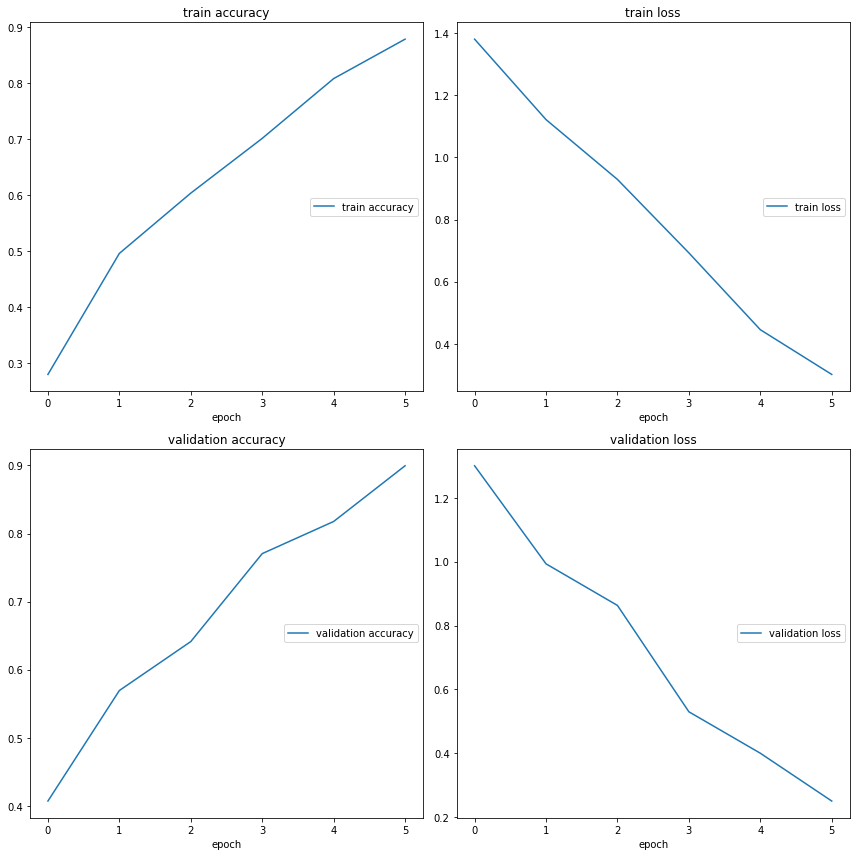

100%|██████████| 6/6 [06:33<00:00, 65.54s/it]

train accuracy
	train accuracy   	 (min:    0.279, max:    0.879, cur:    0.879)
train loss
	train loss       	 (min:    0.302, max:    1.380, cur:    0.302)
validation accuracy
	validation accuracy 	 (min:    0.407, max:    0.900, cur:    0.900)
validation loss
	validation loss  	 (min:    0.251, max:    1.300, cur:    0.251)
Epoch: 06
	Train Loss: 0.302 | Train Acc: 87.91%
	 Val. Loss: 0.251 |  Val. Acc: 89.95%


In [25]:
# train and plotting portion
avg_train_acc = 0
avg_valid_acc = 0
k_fold = 5
for idx in range(k_fold):
  
  # setting model parameters
  # model_to_use = AlexNet(num_classes=4)
  model_to_use = VGG.from_name("vgg11")
  LR = 1e-5
  optimizer = optim.Adam(model_to_use.parameters(), lr = LR)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  loss_function = nn.CrossEntropyLoss()
  model_to_use = model_to_use.to(device)
  loss_function = loss_function.to(device)

  train_dataloader, valid_dataloader = kfold(idx, split_dataset, split_labels)
  liveloss = PlotLosses()
  results = {}
  epochs = 8

  for epoch in tqdm.tqdm(range(epochs)):
      
      train_loss, train_acc = train(model_to_use, train_dataloader, optimizer, loss_function, device)
      valid_loss, valid_acc = validate(model_to_use, valid_dataloader, loss_function, device)

      results['train accuracy'] = train_acc
      results['train loss'] = train_loss
      results['validation accuracy'] = valid_acc   
      results['validation loss'] = valid_loss
      liveloss.update(results)
      liveloss.send()

      
      print(f'Epoch: {epoch}')
      print(f'Train Loss: {train_loss:.3f}  Train Acc: {train_acc*100:.2f}%')
      print(f'Validation Loss: {valid_loss:.3f}   Validation Acc: {valid_acc*100:.2f}%')
  avg_train_acc += train_acc
  avg_valid_acc += valid_acc

In [17]:
# prepare the data for pytorch dataloader
test_data = Data(test_images, test_labels, test_transform)
test_dataloader = DataLoader(test_data, batch_size = 1)

In [25]:
print("Kfold train accuracy: ")
print((avg_train_acc / 5) * 100)

print("Kfold validation accuracy: ")
print((avg_valid_acc / 5) * 100)

Kfold train accuracy: 
96.78681392746277
Kfold validation accuracy: 
94.2191043354216


In [26]:
# predictions
images, labels, probs = predict(model_to_use, test_dataloader)
pred_labels = torch.argmax(probs, 1)

In [27]:
accuracy = accuracy_score(labels, pred_labels)
print("Accuracy of CNN model: %.2f%%" % (accuracy * 100.0))

Accuracy of CNN model: 74.55%


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

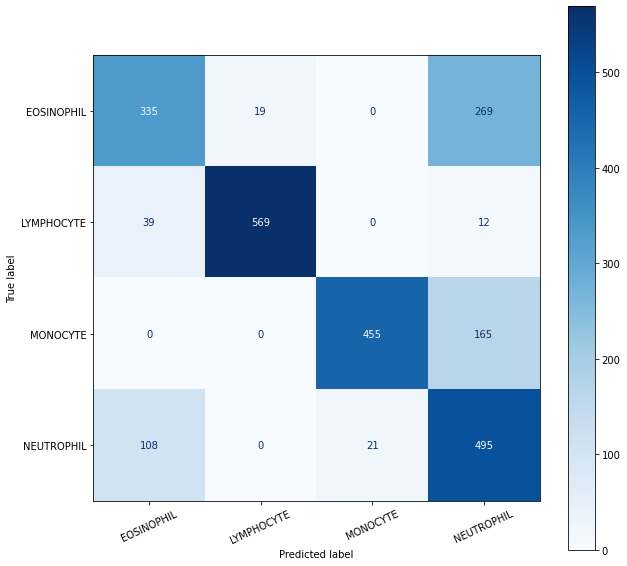

In [33]:
# confusion matrix
classes = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]
fig = plt.figure(figsize = (10, 10));
ax = fig.add_subplot(1, 1, 1);
cm = confusion_matrix(labels, pred_labels);
cm = ConfusionMatrixDisplay(cm, display_labels = classes);
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.xticks(rotation = 25)

ROC AUC score: 0.8303645768275941


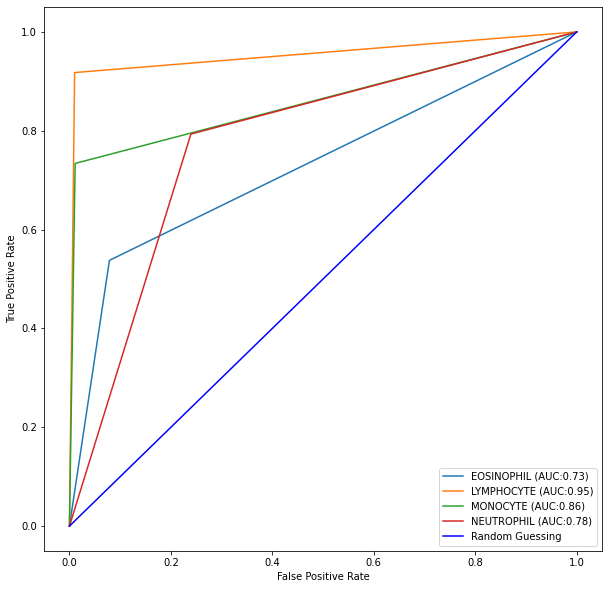

In [29]:
# ROC AUC plot
fig, c_ax = plt.subplots(1,1, figsize = (10, 10))
y_test = labels.detach().numpy()
y_pred = pred_labels.detach().numpy()
lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred = lb.transform(y_pred)
for (idx, c_label) in enumerate(classes):
    f, t, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(f, t, label = '%s (AUC:%0.2f)'  % (c_label, auc(f, t)))
c_ax.plot(f, f, 'b-', label = 'Random Guessing')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
score = roc_auc_score(y_test, y_pred, average="macro")
print(f'ROC AUC score: {score}')
plt.show()

Multiclass SVM



In [36]:
train = []
train_labels = y
validation_images = []
validation_labels = valid_labels
for img_path in x:
  img = Image.open(img_path)
  img = np.asarray(img).flatten()
  train.append(img)
for img_path in valid:
  img = Image.open(img_path)
  img = np.asarray(img).flatten()
  validation_images.append(img)

In [38]:
svm_model = OneVsRestClassifier(SVC(kernel='linear')).fit(train, train_labels)

In [44]:
predictions = svm_model.predict(validation_images)

In [46]:
accuracy = accuracy_score(validation_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 32.67%
